### Inverstigation of transcription factor - receptor connection and the relatioship in correlation with coeff matrix and TF activity

In [1]:
import pandas as pd
import numpy as np
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from src.config import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


##### KEGG pathways

In [2]:
with open(f'data/genesets/c2.cp.kegg.v2023.1.Hs.symbols.gmt') as gmt:
    file_contents = (gmt.read())

In [3]:
file_contents = file_contents.split('\n')
file_contents = file_contents[:-1]
kegg_pws = {}
for line in file_contents:
    elements = line.split('\t')  # Split each line into elements using '\t' as the separator
    id_ = elements[0]  # First element is the ID
    elements_list = elements[2:]  # Elements starting from the third element
    kegg_pws[id_] = elements_list

##### TF activity

In [4]:
coefm = pd.read_csv(f'data/coefficient_matrix/high_quality/all_pert_coef_liana.csv', index_col = 0)

In [5]:
receptors = list(coefm.index)
len(receptors)

229

In [6]:
# Load TF regulon and calcukate TF activity
dorothea = dc.get_dorothea(levels = ['A', 'B', 'C'])
tf_acts, tf_pvals = dc.run_consensus(mat=coefm, net=dorothea)

/Users/basvaat/opt/anaconda3/envs/ccc_py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
tfs = list(tf_acts.columns)

In [8]:
tf_acts_z = tf_acts.copy()

In [9]:
def calculate_z_score(col:pd.Series):
    if np.std(col) == 0:
        return np.nan
    return (col - np.mean(col)) / np.std(col)

In [10]:
tf_acts_z = tf_acts_z.apply(calculate_z_score, axis = 0)

In [11]:
tf_acts_abs  = tf_acts_z.abs()

In [12]:
print(len(tfs), len(receptors), len(kegg_pws.keys()))
pairs = {}
for receptor in receptors:
    for tf in tfs:
        cnt = 0
        for pw in kegg_pws:
            proteinlist = kegg_pws[pw]
            if tf in proteinlist and receptor in proteinlist:
                cnt += 1
        pairs[receptor+'_'+tf] = cnt
        

180 229 186


In [13]:
pairs_yesno = {key: (1 if value >= 1 else 0) for key, value in pairs.items()}


In [14]:
in_pathway_df = pd.DataFrame.from_dict(pairs_yesno, orient='index')
in_pathway_df.index = in_pathway_df.index.str.split('_', expand=True)
in_pathway_df = in_pathway_df.reset_index()
in_pathway_df.columns = ['receptors', 'tfs', 'value']
in_pathway_df = in_pathway_df.pivot(index='receptors', columns='tfs', values='value')


In [15]:
in_pathway_df = pd.DataFrame([[key.split('_')[0], key.split('_')[1], value] for key, value in pairs_yesno.items()],
                  columns=['receptors', 'tfs', 'isinpw'])

In [16]:
tf_acts_abs_melted = tf_acts_abs.reset_index().melt(id_vars='index', var_name='tfs', value_name='activity')
tf_acts_abs_melted = tf_acts_abs_melted.rename(columns = {'index':'receptors'})

In [17]:
merged_df = pd.merge(in_pathway_df, tf_acts_abs_melted, on=['receptors', 'tfs'])

In [18]:
# merged_df.to_csv(f'results/biological_relevance/kegg_receptor_tf.csv')


In [20]:
# Separate the values based on categories
outpw = merged_df[merged_df['isinpw'] == 0]['activity']
inpw = merged_df[merged_df['isinpw'] == 1]['activity']

# Perform Mann-Whitney U test
# mannwhitneyu(outpw, inpw)
ttest_ind(outpw, inpw)


Ttest_indResult(statistic=-4.313024664929356, pvalue=1.6141012037226888e-05)

([<matplotlib.axis.XTick at 0x135920580>,
 [Text(0, 0, 'no'), Text(1, 0, 'yes')])

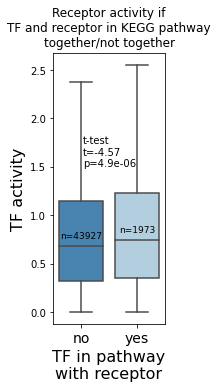

In [56]:
fig, ax = plt.subplots(figsize = (2, 5))
sns.boxplot(data=merged_df, x='isinpw', y='activity', palette = 'Blues_r', showfliers = False)
plt.title('Receptor activity if\nTF and receptor in KEGG pathway\ntogether/not together')
plt.xlabel('TF in pathway\nwith receptor', fontsize=16)
plt.ylabel('TF activity', fontsize=16)
ax.text(0, np.median(outpw)+0.1, 'n='+str(len(outpw)), ha='center', va='center', color='k', fontsize=9)
ax.text(1, np.median(inpw)+0.1, 'n='+str(len(inpw)), ha='center', va='center', color='k', fontsize=9)
ttestres = ttest_ind(outpw, inpw)
ax.text(0.03, 1.5, str("t-test\nt="+"{:.2f}".format(ttestres[0])+"\np="+"{:.1e}".format(ttestres[1])), ha='left')
plt.xticks(range(2), ['no', 'yes'], fontsize=14)
# plt.savefig('figures/validation/biological_relevance/in_pathway_boxplot_tf_kegg_blue.pdf', transparent = True, bbox_inches = 'tight')
# plt.savefig('figures/validation/biological_relevance/in_pathway_boxplot_tf_kegg_blue.png', transparent = True, bbox_inches = 'tight', dpi = 300)